In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

nltk.download('punkt')
nltk.download('stopwords')


steam1 = pd.read_csv('steam1.csv')
steam2 = pd.read_csv('steam2.csv')
# steam3 = pd.read_csv('steam3.csv', low_memory=False)
steam4 = pd.read_csv('steam4.csv')
steam5 = pd.read_csv('steam5.csv')
s1 = pd.read_csv('s1.csv')
s2 = pd.read_csv('s2.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lolo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lolo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Initialize Sentiment Analyzer
sentiment = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    if pd.isna(text):
        return np.nan
    scores = sentiment.polarity_scores(text)
    return scores['compound']

# Apply sentiment analysis
steam1['sentiment_score'] = steam1['description'].apply(analyze_sentiment)
s1['sentiment_score'] = s1['description'].apply(analyze_sentiment)
merged_data = pd.merge(s1, s2, left_on='name', right_on='game_name', how='outer')
merged_data['sentiment_score'] = merged_data['description'].apply(analyze_sentiment)
print(merged_data['sentiment_score'].describe())

count    7496.000000
mean        0.021311
std         0.597071
min        -0.992900
25%        -0.541100
50%         0.000000
75%         0.584800
max         0.987600
Name: sentiment_score, dtype: float64


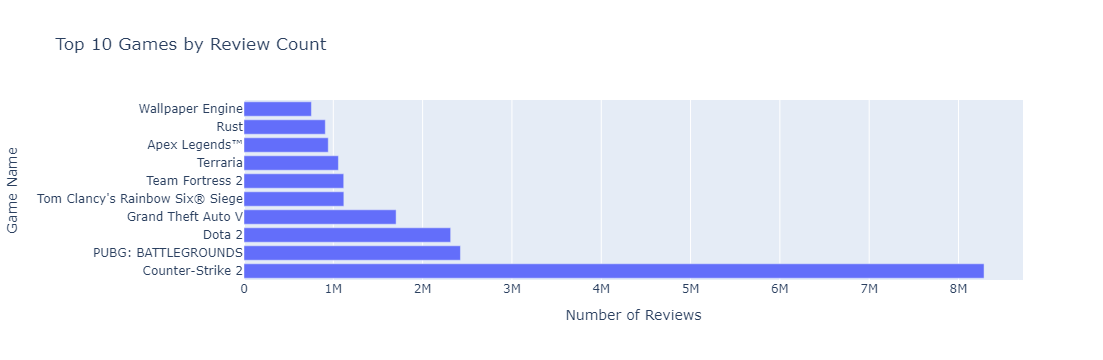

In [11]:
top_n = 10  
top_games = steam1.nlargest(top_n, 'review_no')

fig1 = px.bar(top_games, y='name', x='review_no', orientation='h', title="Top 10 Games by Review Count")
fig1.update_xaxes(title="Number of Reviews")
fig1.update_yaxes(title="Game Name")
fig1.show()

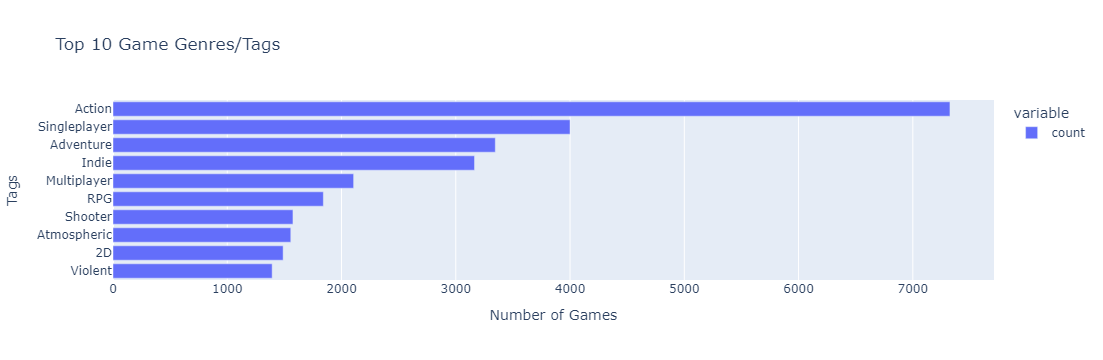

In [12]:
s1['tags'] = s1['tags'].fillna('')
s1['tag_list'] = s1['tags'].str.split(',')
tags = s1.explode('tag_list')
tags['tag_list'] = tags['tag_list'].str.strip()
tags = tags[tags['tag_list'] != '']

tag_counts = tags['tag_list'].value_counts().head(10)

fig2 = px.bar(tag_counts[::-1], orientation='h', title='Top 10 Game Genres/Tags')
fig2.update_layout(yaxis_title='Tags', xaxis_title='Number of Games')
fig2.show()

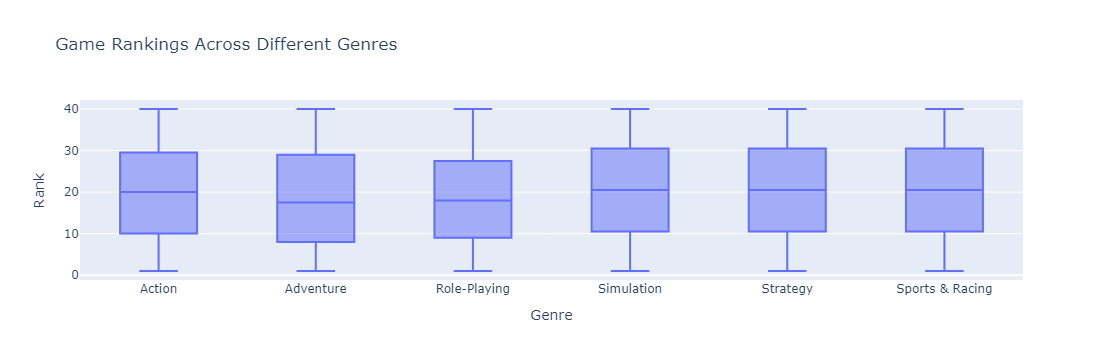

In [13]:
fig3 = px.box(steam4, x='genre', y='rank', title='Game Rankings Across Different Genres')
fig3.update_layout(xaxis_title='Genre', yaxis_title='Rank')
fig3.show()

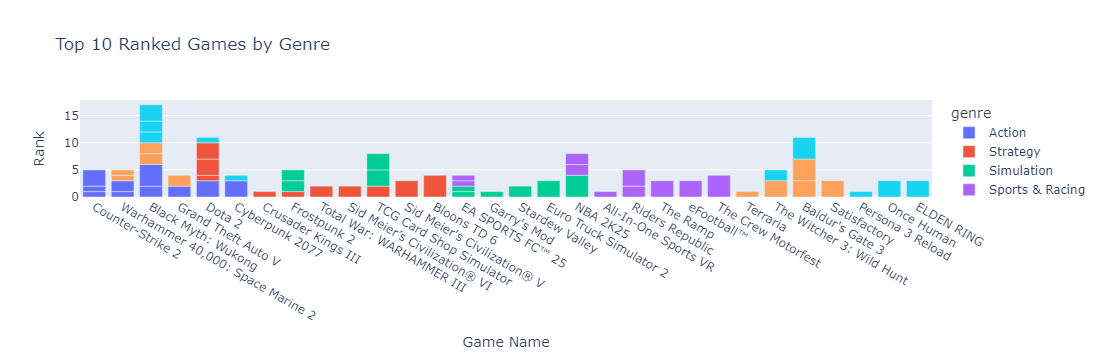

In [14]:
top_n_rank = 10  
top_ranked_games = steam4.sort_values(by='rank').groupby('genre').head(top_n_rank)
fig4 = px.bar(top_ranked_games, x='game_name', y='rank', color='genre', title='Top 10 Ranked Games by Genre', 
              labels={'rank':'Rank', 'game_name':'Game Name'}, hover_name='game_name')
fig4.update_layout(xaxis_title='Game Name', yaxis_title='Rank')
fig4.show()

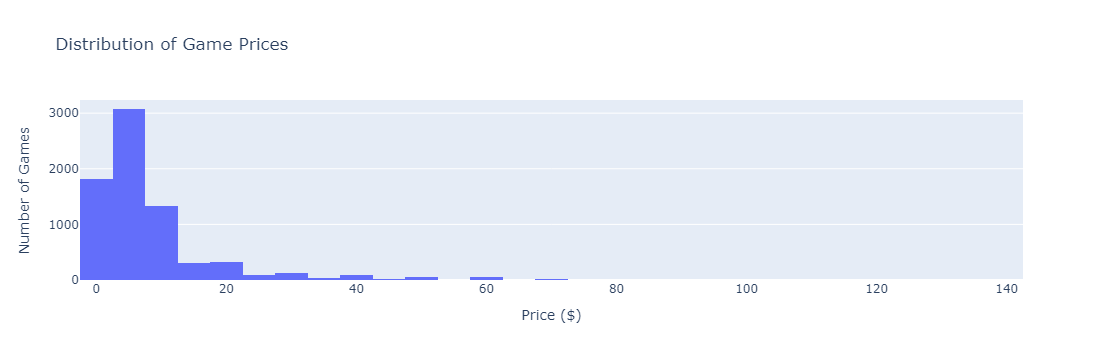

In [15]:
fig5 = px.histogram(s1, x='price_x', nbins=50, title='Distribution of Game Prices')
fig5.update_xaxes(title='Price ($)')
fig5.update_yaxes(title='Number of Games')
fig5.show()

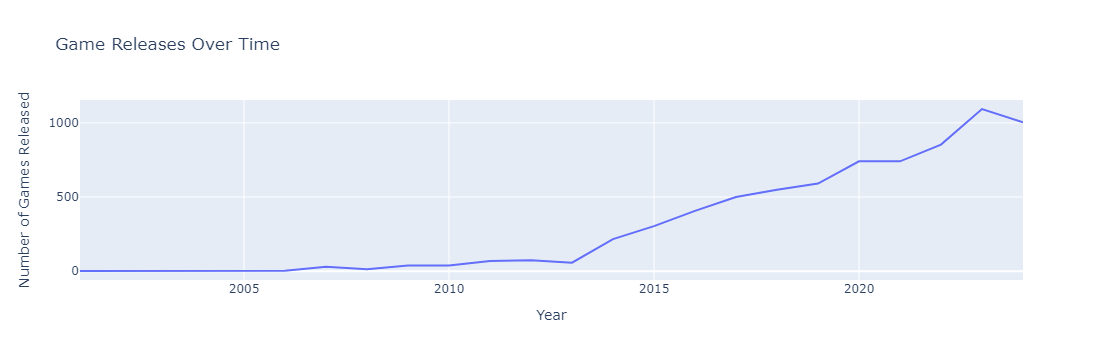

In [16]:
steam1['release_date'] = pd.to_datetime(steam1['release_date'], errors='coerce')
steam1 = steam1.dropna(subset=['release_date'])
release_date_trend = steam1.groupby(steam1['release_date'].dt.year).size()
fig6 = px.line(release_date_trend, x=release_date_trend.index, y=release_date_trend.values, title="Game Releases Over Time")
fig6.update_xaxes(title="Year")
fig6.update_yaxes(title="Number of Games Released")
fig6.show()

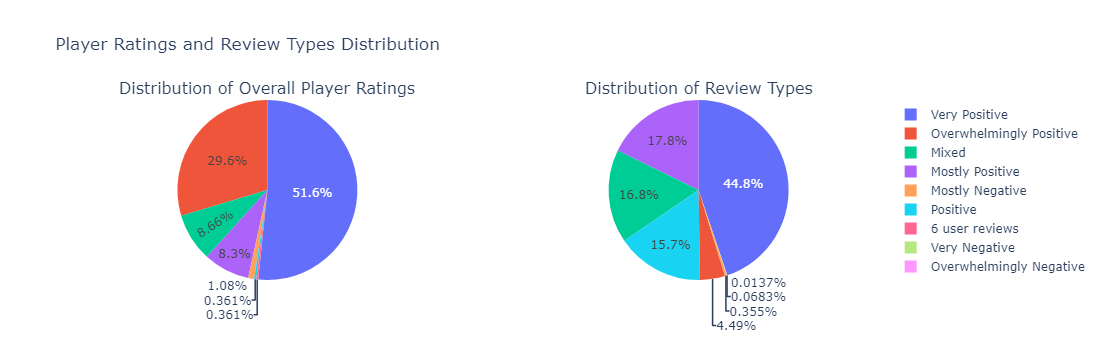

In [17]:
rating_distribution = steam5['overall_player_rating'].value_counts().reset_index()
rating_distribution.columns = ['overall_player_rating', 'count']
review_type_counts = steam1['review_type'].value_counts().reset_index()
review_type_counts.columns = ['review_type', 'count']
fig7 = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type':'domain'}, {'type':'domain'}]],
    subplot_titles=['Distribution of Overall Player Ratings', 'Distribution of Review Types']
)
fig7.add_trace(
    go.Pie(labels=rating_distribution['overall_player_rating'], values=rating_distribution['count']),
    row=1, col=1
)
fig7.add_trace(
    go.Pie(labels=review_type_counts['review_type'], values=review_type_counts['count']),
    row=1, col=2
)
fig7.update_layout(title_text='Player Ratings and Review Types Distribution')
fig7.show()

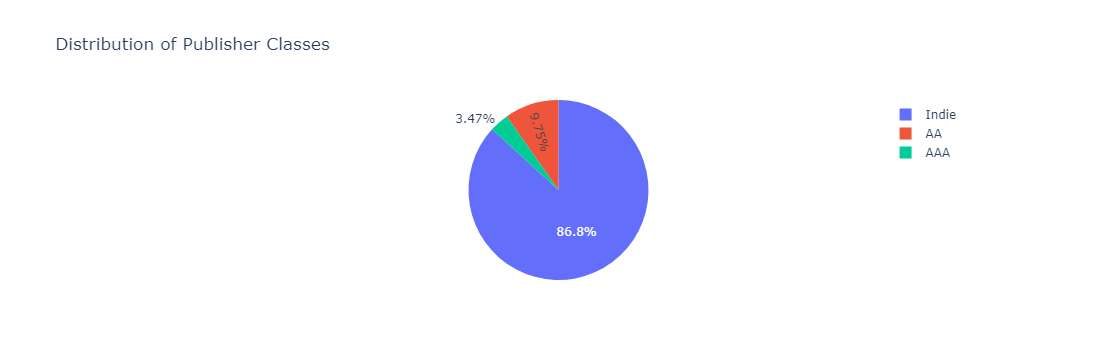

In [18]:
fig8 = px.pie(steam2, names='publisherclass', title='Distribution of Publisher Classes')
fig8.show()

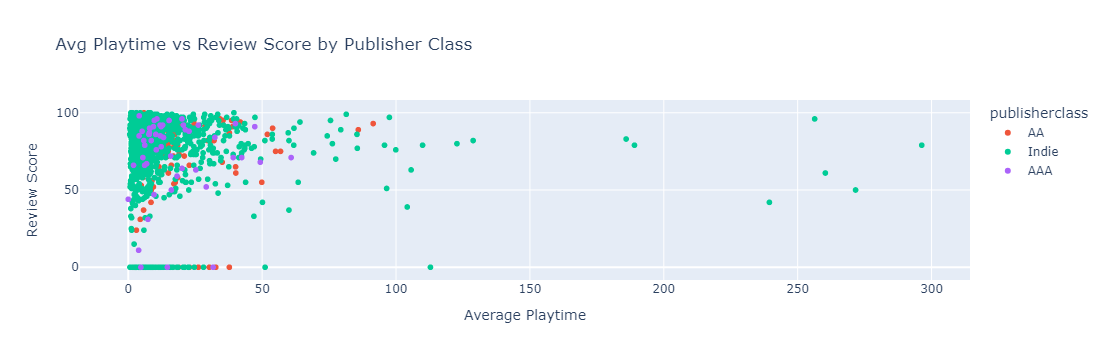

In [19]:
fig9 = px.scatter(s1, x='avgplaytime', y='reviewscore', color='publisherclass', title='Avg Playtime vs Review Score by Publisher Class')
fig9.update_xaxes(title='Average Playtime')
fig9.update_yaxes(title='Review Score')
fig9.show()

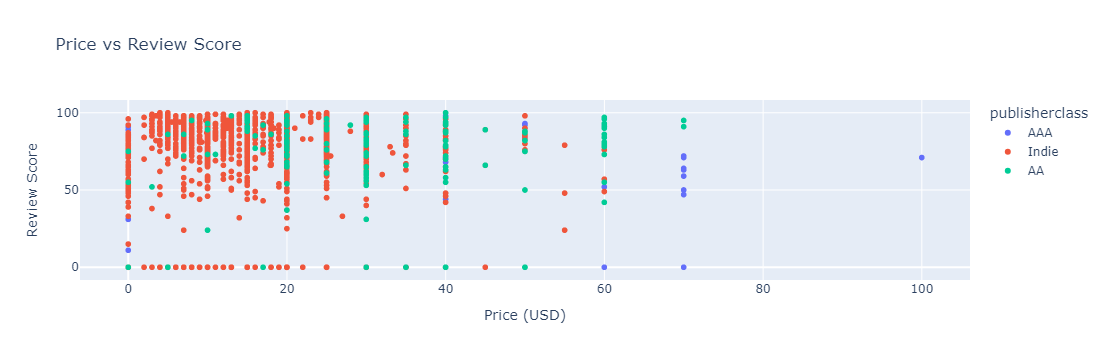

In [20]:
fig10 = px.scatter(steam2, x='price', y='reviewscore', title="Price vs Review Score", hover_data=['name'], color='publisherclass')
fig10.update_xaxes(title="Price (USD)")
fig10.update_yaxes(title="Review Score")
fig10.show()

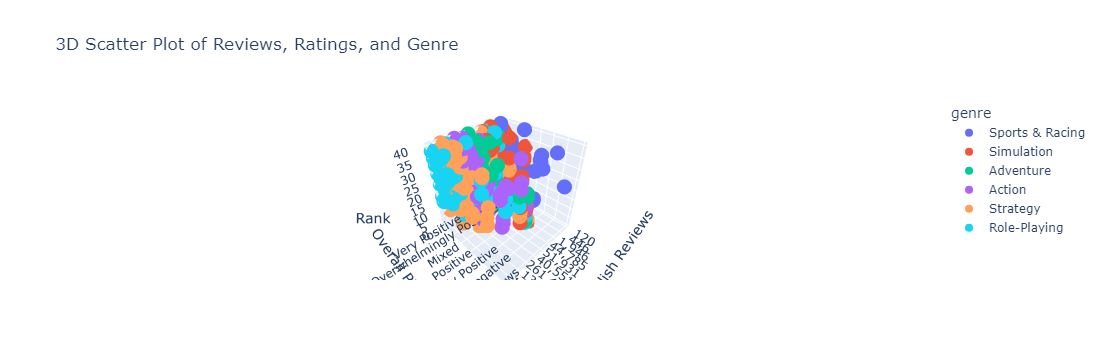

In [21]:
fig11 = px.scatter_3d(s2, x='number_of_english_reviews', y='overall_player_rating', z='rank', color='genre', title='3D Scatter Plot of Reviews, Ratings, and Genre')
fig11.update_layout(scene=dict(
    xaxis_title='Number of English Reviews',
    yaxis_title='Overall Player Rating',
    zaxis_title='Rank'
))
fig11.show()

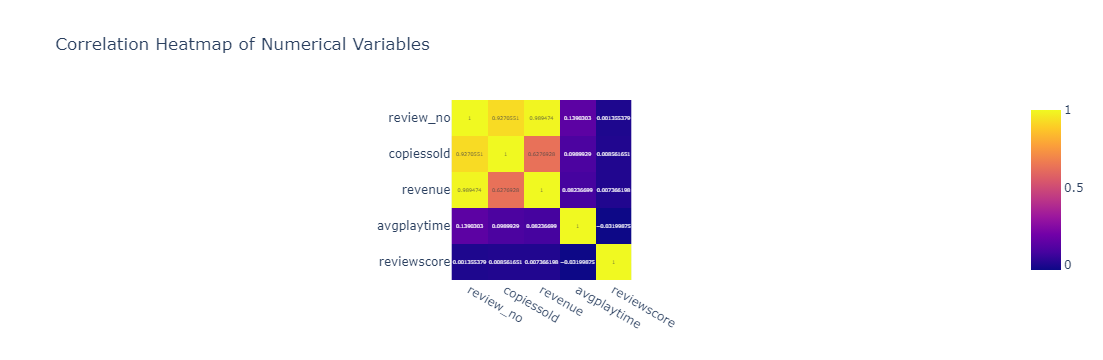

In [22]:
numeric_cols = ['review_no', 'copiessold', 'revenue', 'avgplaytime', 'reviewscore']
corr_matrix = s1[numeric_cols].corr()

fig12 = px.imshow(corr_matrix, text_auto=True, title='Correlation Heatmap of Numerical Variables')
fig12.show()

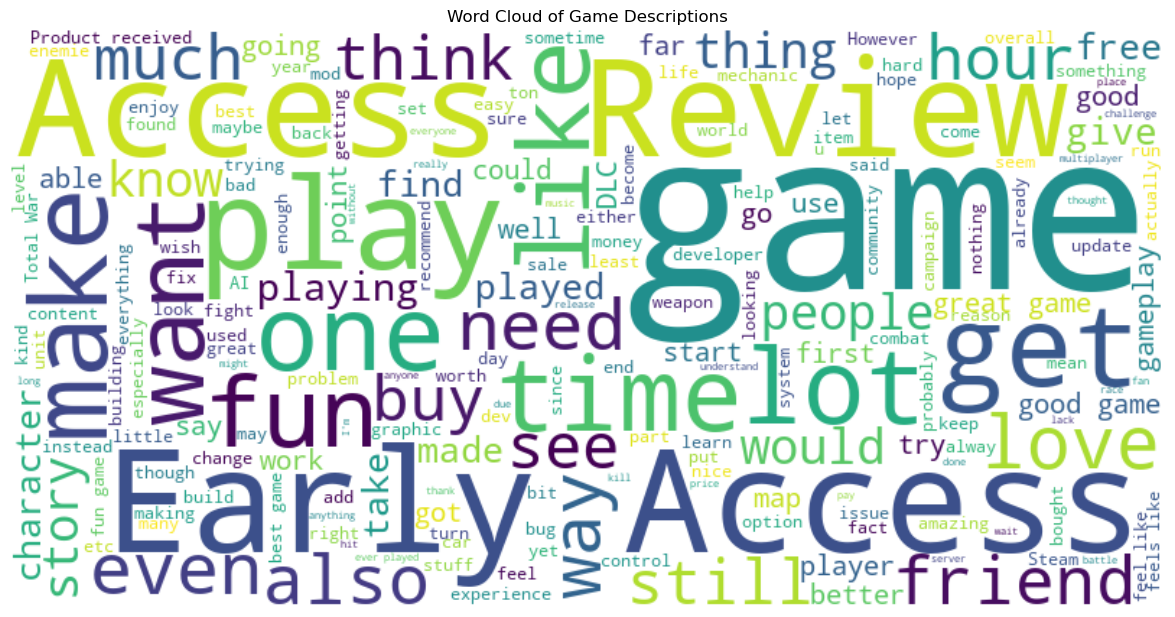

In [23]:
text = ' '.join(steam3['review'].dropna())

stop_words = set(stopwords.words('english'))
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Game Descriptions')
plt.show()

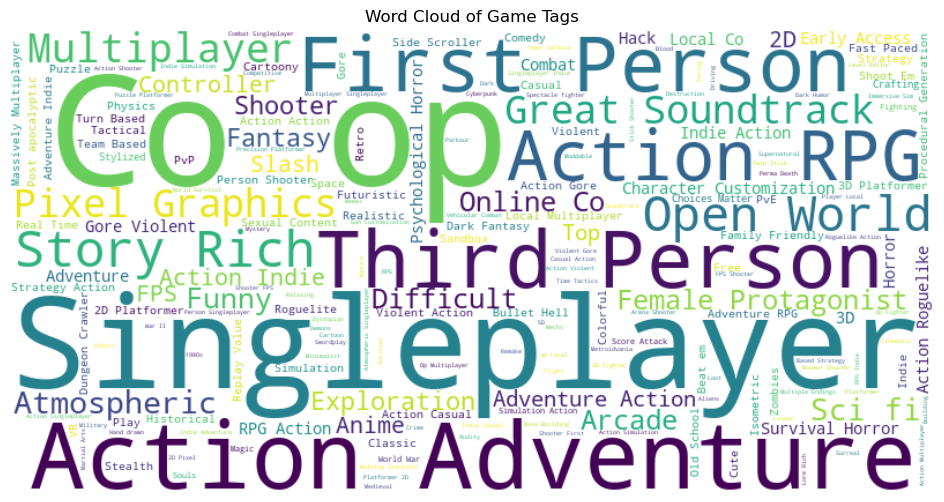

In [24]:
all_tags = ' '.join(s1['tags'].dropna())

wordcloud_tags = WordCloud(width=800, height=400, background_color='white').generate(all_tags)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_tags, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Game Tags")
plt.show()

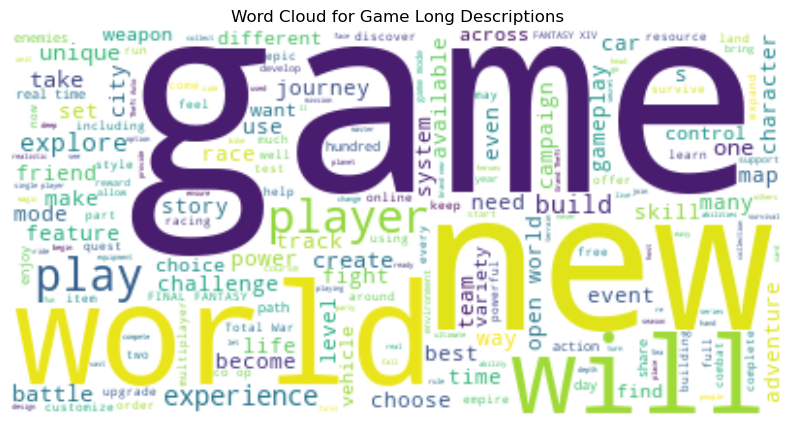

In [25]:
long_desc_text = ' '.join(s2['long_description'].dropna())
wordcloud_long_desc = WordCloud(background_color="white", max_words=200).generate(long_desc_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_long_desc, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Game Long Descriptions')
plt.show()

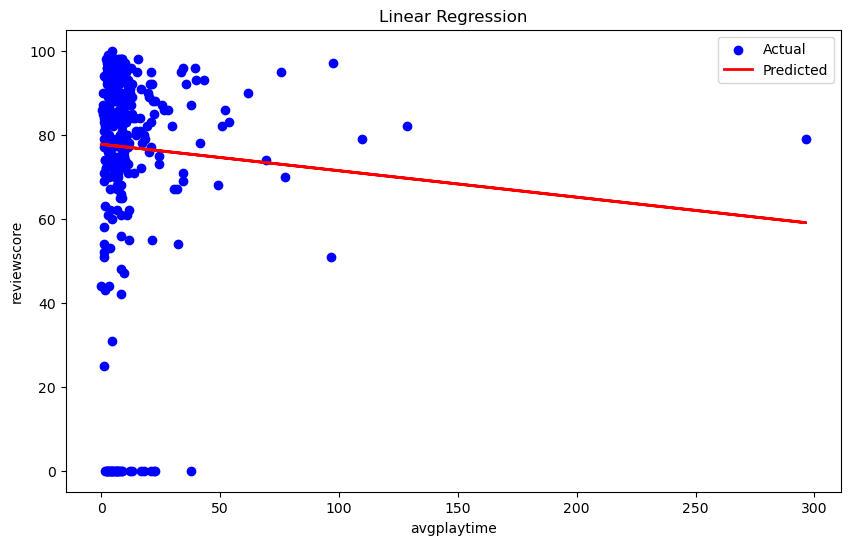

MSE: 767.32
R²: -0.03


In [26]:
numeric_cols = s1.select_dtypes(include=['float64', 'int64']).columns.tolist()
x_var = 'avgplaytime' if 'avgplaytime' in numeric_cols else numeric_cols[0]
y_var = 'reviewscore' if 'reviewscore' in numeric_cols else numeric_cols[1]

X = s1[[x_var]].dropna()
y = s1[y_var][X.index].dropna()
X = X.loc[y.index]
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(10,6))
plt.scatter(X_test[x_var], y_test, color='blue', label='Actual')
plt.plot(X_test[x_var], y_pred, color='red', linewidth=2, label='Predicted')
plt.title('Linear Regression')
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.legend()
plt.show()

print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

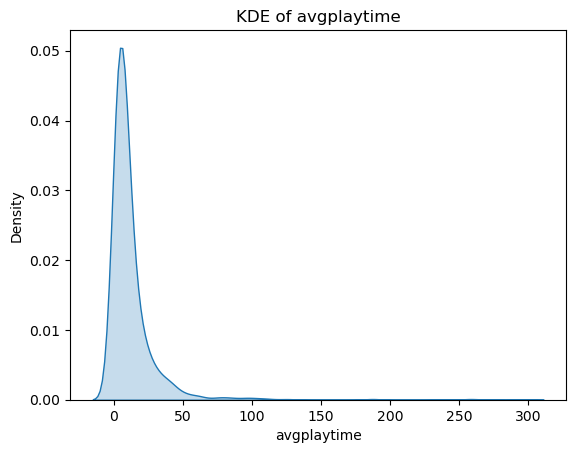

In [28]:
x = x_var 
sns.kdeplot(data=s1, x=x, fill=True)
plt.title(f'KDE of {x}')
plt.xlabel(x)
plt.ylabel('Density')
plt.show()

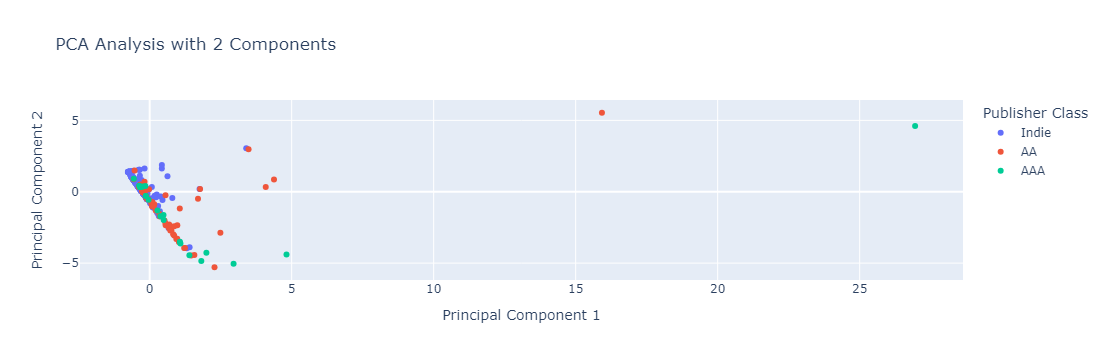

In [29]:
pca_vars = numeric_cols[:5] 

X_pca = s1[pca_vars].dropna()
X_scaled = StandardScaler().fit_transform(X_pca)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data=principalComponents, columns=['Principal Component 1', 'Principal Component 2'])
finalDf = pd.concat([principalDf.reset_index(drop=True), s1[['publisherclass']].iloc[X_pca.index].reset_index(drop=True)], axis=1)

fig_pca1 = px.scatter(finalDf, x='Principal Component 1', y='Principal Component 2', color='publisherclass',
                      title='PCA Analysis with 2 Components', labels={'publisherclass': 'Publisher Class'})
fig_pca1.show()

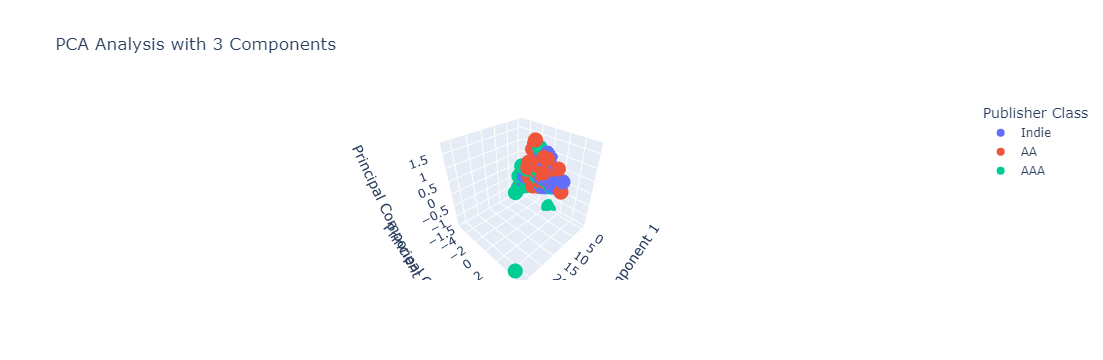

In [30]:
pca_3d = PCA(n_components=3)
principalComponents_3d = pca_3d.fit_transform(X_scaled)
principalDf_3d = pd.DataFrame(data=principalComponents_3d, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
finalDf_3d = pd.concat([principalDf_3d.reset_index(drop=True), s1[['publisherclass']].iloc[X_pca.index].reset_index(drop=True)], axis=1)

fig_pca2 = px.scatter_3d(finalDf_3d, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3', color='publisherclass',
                         title='PCA Analysis with 3 Components', labels={'publisherclass': 'Publisher Class'})
fig_pca2.show()

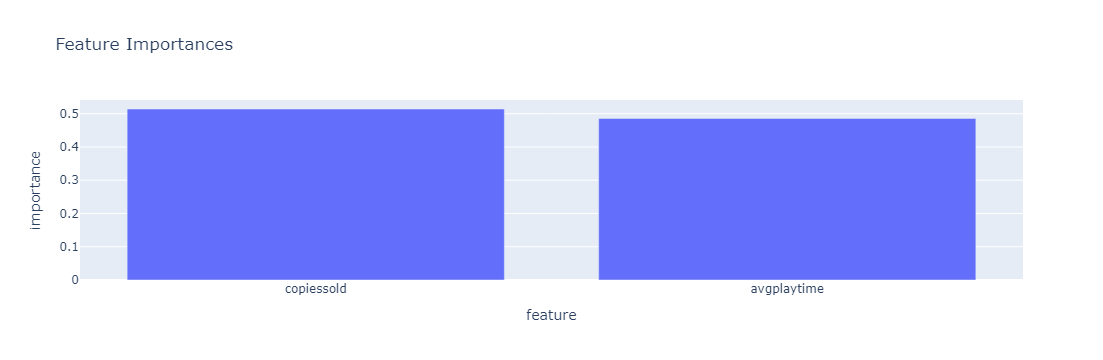

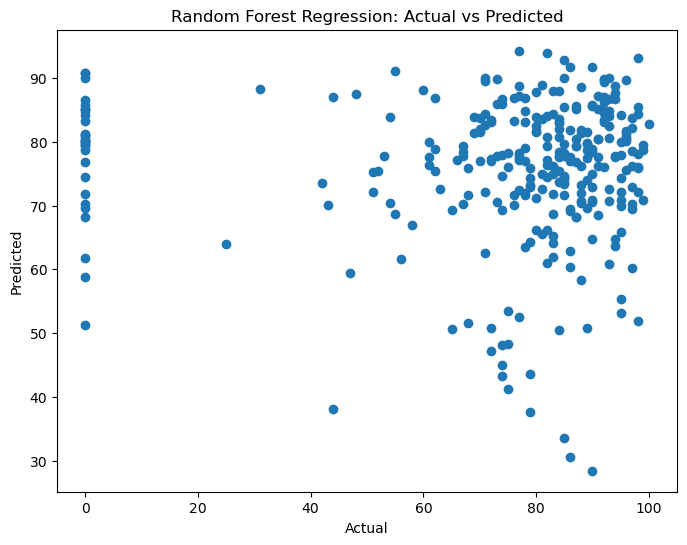

MSE: 903.82
R²: -0.21


In [31]:
target_var = 'reviewscore'
feature_vars = ['avgplaytime', 'copiessold'] 

X_rf = s1[feature_vars].dropna()
y_rf = s1[target_var][X_rf.index].dropna()
X_rf = X_rf.loc[y_rf.index]
y_rf = y_rf.loc[X_rf.index]

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

y_pred_rf = rf_model.predict(X_test_rf)

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_vars, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

fig_rf = px.bar(feature_importance_df, x='feature', y='importance', title='Feature Importances')
fig_rf.show()

plt.figure(figsize=(8,6))
plt.scatter(y_test_rf, y_pred_rf)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Regression: Actual vs Predicted')
plt.show()

print(f"MSE: {mean_squared_error(y_test_rf, y_pred_rf):.2f}")
print(f"R²: {r2_score(y_test_rf, y_pred_rf):.2f}")